# Predicting Long-Term Mortality: Evidence from the Health and Retirement Study

### S0. problem formulation

#### Background:

The current academic literature in predicting mortality has extensively focused on disease and frailty, although social, behavioral, and psychological statuses may herald broad physiological decline. I tested the effectiveness of the machine learning algorithms on the NSHAP sample in Project 1 and learnt the important features predicting mortality. This project will extend the analysis by 1) using a different set of predictors 2) applying some new algorithms in addition to tree-based algorithm 3) using a different dataset.

#### Context:

Health and Retirement Survey (HRS) is a nationally representative survey of the older US adults (aged 50-61) collected every two years from 1992 to 2018. I use 2002 characteristics as baseline and 2016 disposition status (reported in the 2018 wave) as target (n = 20218). The choice of the baseline year of 2002 is because the 2002 wave is the first wave of the HRS that have consistent and detailed health-related measurements. 

#### Goal
The goal of this project is to predict mortality in the next 14 years using the baseline characteristics in 2002. I will also discussed the social and demographic characteristics of the cases whose disposition statuses were either wrongly predicted as death or alive by the algorithms. The findings will serve important purposes for public health practitioners in understanding the risk and protective factors of mortality in the aging process.

#### Task: 
The task is to train a binary classification model to predict mortality in the next 14 years using the baseline characteristics in 2002.

#### Dataset Links:
<a href= "https://hrs.isr.umich.edu/sites/default/files/meta/2002/core/codebook/h02_00.html?_ga=2.14020593.714056361.1676427746-1610833755.1676427746">Codebook</a>

<a href= "https://hrs.isr.umich.edu/data-products">Dataset</a>

#### List of features I will be using:
1. Body mass index: HRS: HC139 - weight in pounds (continuous)
2. Hypertension: HRS: HC005 (binary)
3. Diabetes: HRS: HC010 (binary)
4. Self-rated health: HRS: HC001 (ordinal)
5. Arthritis: HRS: HC070 (binary)
6. Smoking: HRS: HC117 (binary)
7. Drunk alcohol: HRS: HC128 (binary)
8. Age at baseline: HRS: HX067_R (ordinal, year of birth)
9. Education: NSHAP: HRS: HB014A (ordinal)
10. Net household assets: HRS: HC134 + HQ331 + HQ376 (continuous)
11. Marital status: HRS: HMARITAL (binary)
12. Sex: HRS: HX060_R (binary)
13. Race: NSHAP: HRS: HB031A (binary)
14. Religion Importance:  HRS: HB053 (ordinal)
15. Children co-residence: HRS: HE012 (binary)
16. Grandchildren: HRS: HE046 (ordinal)
17. Relatives: HRS: HF174 (binary)
18. Volunteer: HRS: HG092 (binary)
19. Friends: HRS: HF176 (ordinal)
20. Functional limitations: HRS: HG001 (binary)

#### Import packages for the analysis

In [1]:
# Data Preprocessing package
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning package
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch

import matplotlib.pyplot as plt

seed = 42

/opt/anaconda3/envs/MACS/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### S1: Exploratory Data Analysis & Data Preprocessing

Because the HRS dataset of each wave (e.g., 2002) is stored in 20+ files (in multiple formates), I first need to merge the files into one dataframe. The following code is used to merge the files. I used the CSV version of the HRS raw dataset.

I have concatenated the disposition statuses of the 8 subsequent waves since 2002 until 2018 to create a new variable called "disposition" that indicates the status of the respondents in 2018. The disposition status is coded as 0 (alive) and 1 (dead) in the new variable. Those not in the disposition datasets are still alive.

In [2]:
# Import all the core files in the baseline wave 2002
all_core_files = glob.glob('hrs_data/*.csv')
# Create an empty dataframe to concatenate with all the dataframes
core_data_raw = pd.DataFrame()
# Loop through all the files and read them into a dataframe
for filename in all_core_files:
    dfcore = pd.read_csv(filename, index_col=None, header=0)
    col_to_merge = dfcore.columns.difference(core_data_raw.columns)
    if filename.endswith('R.csv'):
        core_data_raw = pd.concat([core_data_raw, dfcore[col_to_merge]], axis=1)
    elif filename.endswith('H.csv'):
        dfmerge = pd.concat([dfcore[col_to_merge], dfcore['HHID']], axis=1)
        core_data_raw = core_data_raw.merge(dfmerge,
                                            on=["HHID"], how="inner")
# Select the columns we need
core_data = core_data_raw[['HHID', 'PN',
                           'HC139', 'HC005', 'HC010', 'HC001', 'HC070', 
                           'HC117', 'HC128', 'HX067_R', 'HB014A', 'HC134', 'HQ331', 'HQ376', 'HMARITAL', 'HX060_R', 'HB031A',
                           'HB053', 'HE012', 'HE046', 'HF174', 'HG092', 'HF176',
                           'HG001'
                           ]]
# Show the first 5 rows of the dataframe
core_data.head()

,HHID,PN,HC139,HC005,HC010,HC001,HC070,HC117,HC128,HX067_R,...,HMARITAL,HX060_R,HB031A,HB053,HE012,HE046,HF174,HG092,HF176,HG001
0,3,10,170.0,5.0,5.0,3.0,5.0,5.0,1.0,1936.0,...,1.0,1.0,1.0,1,5.0,12.0,5.0,20.0,1.0,5.0
1,3,20,179.0,5.0,5.0,3.0,1.0,5.0,5.0,1938.0,...,1.0,2.0,1.0,1,5.0,12.0,5.0,100.0,1.0,5.0
2,10001,10,180.0,5.0,5.0,2.0,5.0,5.0,5.0,1939.0,...,6.0,1.0,1.0,3,NaN,NaN,5.0,9998.0,3.0,5.0
3,10003,30,120.0,1.0,5.0,1.0,5.0,5.0,5.0,1956.0,...,5.0,2.0,1.0,1,NaN,NaN,5.0,0.0,0.0,5.0
4,10004,10,230.0,1.0,5.0,2.0,1.0,5.0,1.0,1939.0,...,1.0,1.0,1.0,1,1.0,95.0,1.0,200.0,1.0,5.0


In [3]:
# Importing all disposition files of every wave
all_dispositon_files = glob.glob('hrs_data/disposition/*.csv')
# Create an empty dataframe to store all the dataframes
dispositon_data_full = pd.DataFrame()
# Loop through all the files and read them into a list of dataframes
for filename in all_dispositon_files:
    df_disposition = pd.read_csv(filename, index_col=None, header=0)
    dispositon_data_full = pd.concat([dispositon_data_full, df_disposition], axis=0, ignore_index=True)
# Concatenate all the dataframes into one dataframe
dispositon_data = dispositon_data_full.iloc[:, :2].copy()
# As these are all the disposition files, we can set deceased to 1
dispositon_data['deceased'] = 1
dispositon_data

,HHID,PN,deceased
0,10475,10,1
1,10592,10,1
2,11219,10,1
3,11575,20,1
4,11626,10,1
...,...,...,...
10027,213379,10,1
10028,213410,10,1
10029,213418,10,1
10030,213428,10,1


After getting the 2002 core dataset and the disposition dataset, I merged the two datasets on the unique identifier "id" to create the final dataset for the analysis.

Then, I have checked whether the outcome variable is balanced. Different from the NSHAP dataset that Zejian and I used in Project 1, the HRS dataset is pretty balaced with 54.3% of the respondents alive and 45.7% of the respondents dead. Hence, working with the balanced dataset allows the machine learning algorithms to learn the patterns of the predictors better on both the alive and deceased classes.

In [4]:
# Merge the core data with the disposition data
df02_d = core_data.merge(dispositon_data, on=["HHID", "PN"], how="left")
# Fill the respondents not appearing in the disposition data as not deceased
df02_d['deceased'] = df02_d['deceased'].fillna(0)
# Show the breakdown of deceased and not deceased
df02_d['deceased'].value_counts()

0.0    10973
1.0     9245
Name: deceased, dtype: int64

In [5]:
#check the data size and display the top 5 rows
df02_d.shape, display(df02_d.head())

,HHID,PN,HC139,HC005,HC010,HC001,HC070,HC117,HC128,HX067_R,...,HX060_R,HB031A,HB053,HE012,HE046,HF174,HG092,HF176,HG001,deceased
0,3,10,170.0,5.0,5.0,3.0,5.0,5.0,1.0,1936.0,...,1.0,1.0,1,5.0,12.0,5.0,20.0,1.0,5.0,1.0
1,3,20,179.0,5.0,5.0,3.0,1.0,5.0,5.0,1938.0,...,2.0,1.0,1,5.0,12.0,5.0,100.0,1.0,5.0,1.0
2,10001,10,180.0,5.0,5.0,2.0,5.0,5.0,5.0,1939.0,...,1.0,1.0,3,NaN,NaN,5.0,9998.0,3.0,5.0,0.0
3,10003,30,120.0,1.0,5.0,1.0,5.0,5.0,5.0,1956.0,...,2.0,1.0,1,NaN,NaN,5.0,0.0,0.0,5.0,0.0
4,10004,10,230.0,1.0,5.0,2.0,1.0,5.0,1.0,1939.0,...,1.0,1.0,1,1.0,95.0,1.0,200.0,1.0,5.0,1.0


((20218, 25), None)

After checking the balance of the outcome variable and the missingness of the predictors, I will go ahead to preprocess the data for the analysis by 1) imputing the missing values separately for continuous and categorical variables 2) construct some variables based on multiple other variables 3) scaling the continuous variables.

##### Preprocessing the continuous/ordinal variables
Here I first preprocess special ordinal variables: household asset and age. Then I scale the continuous variables of household asset using the standard scaler. Finally, I address the missing values of the continuous variables. They are either codes as NA or coded as impractical numbers e.g., 9, 99, 999, 9999, etc. I impute the missing values of the continuous variables using the mean imputation method. I have also set the column names of the continuous variables for the convenience of the analysis.

We see from the descriptive statistics of the continuous variables. They do make sense in reality, except age. There are some very young respondents in a longitidunal study representing US older adults. I will later fix it and provide the reason for the outliers.

In [6]:
# select the continuous and ordinal variables
con_col = ['HC139', 'HC001', 'HB014A', 'HB053', 'HE046', 'HG092', 'HF176',
           'HX067_R', 'HC134', 'HQ331', 'HQ376']
# Create a new dataframe with only continuous/ordinal variables
df02_d_ord = df02_d[con_col].copy()
# Construct the household asset variable
wealth_col = ['HC134', 'HQ331', 'HQ376']
for col in wealth_col:
    # Set values of no wealth to 0
    df02_d_ord[col] = df02_d_ord[col].replace(np.nan, 0)
df02_d_ord['wealth_amt'] = df02_d_ord['HC134'] + df02_d_ord['HQ331'] \
    + df02_d_ord['HQ376']
# Scale the wealth variable to 0-100
scaler = MinMaxScaler(feature_range=(0, 100))
df02_d_ord['wealth_amt'] = scaler.fit_transform(df02_d_ord['wealth_amt']\
    .values.reshape(-1, 1))
df02_d_ord.drop(['HC134', 'HQ331', 'HQ376'], axis=1, inplace=True)
# Construct the age variable
df02_d_ord['age'] = 2002 - df02_d_ord['HX067_R']
df02_d_ord.drop(['HX067_R'], axis=1, inplace=True)
# Set values of missing ordinal variables originally coded as negative to nan
df02_d_ord[df02_d_ord < 0] = np.nan
for i in df02_d_ord.columns:
    if max(df02_d_ord[i]) == 9999:
        df02_d_ord[i] = df02_d_ord[i].replace([9999, 9998], np.nan)
    elif max(df02_d_ord[i]) == 999:
        df02_d_ord[i] = df02_d_ord[i].replace([999, 998], np.nan)
    elif max(df02_d_ord[i]) == 99:
        df02_d_ord[i] = df02_d_ord[i].replace([99, 98, 97, 95], np.nan)
    elif max(df02_d_ord[i]) == 9:
        df02_d_ord[i] = df02_d_ord[i].replace([9, 8], np.nan)
# Check the number of missing values in original ordinal variables
df02_d_ord_nona = df02_d_ord.dropna()
print("Filled {} respondents' missing ordinal variables by mean"\
    .format(len(df02_d_ord) - len(df02_d_ord_nona)))
# Fill the missing values with the mean of the variable
df02_d_ord.fillna(df02_d_ord.mean(), inplace=True)
# Name the columns
df02_d_ord.columns = ['Weight (Pounds)', 'Self-Rated Health', 'Education Yrs',
                      'Religion Importance','Number of Grandchildren', 
                      'Hours of Volunteering', 'Number of Times Socializing',
                      'Wealth', 'Age'
]
# Get the summary statistics of the ordinal variables
df02_d_ord.describe()

Filled 9043 respondents' missing ordinal variables by mean


,Weight (Pounds),Self-Rated Health,Education Yrs,Religion Importance,Number of Grandchildren,Hours of Volunteering,Number of Times Socializing,Wealth,Age
count,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000
mean,171.296493,2.868444,12.100723,1.905974,6.657524,45.703950,1.406329,2.767061,68.788793
std,38.282986,1.112213,3.363827,1.359676,5.093500,165.001137,5.934359,12.135002,9.954431
min,65.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,26.000000
25%,145.000000,2.000000,11.000000,1.000000,3.000000,0.000000,1.000000,0.000000,62.000000
50%,170.000000,3.000000,12.000000,1.000000,6.657524,10.000000,1.000000,0.000000,68.788793
75%,192.000000,4.000000,14.000000,3.000000,7.000000,45.703950,2.000000,0.000000,75.000000
max,400.000000,5.000000,17.000000,5.000000,77.000000,9000.000000,365.000000,100.000000,110.000000


Then, I check the correlation between continuous variables in the dataset. Given that there is no strong correlation between the continuous variables, I do not need to drop any of the continuous variables.

Among the correlations, there is a negative correlation of 0.2 between years of education and number of grandchildren. This is because the number of grandchildren is only available for those who have children and the number of children is positively correlated with years of education. Therefore, the number of grandchildren is negatively correlated with years of education. However, the correlation is not strong enough to drop either of the two variables.

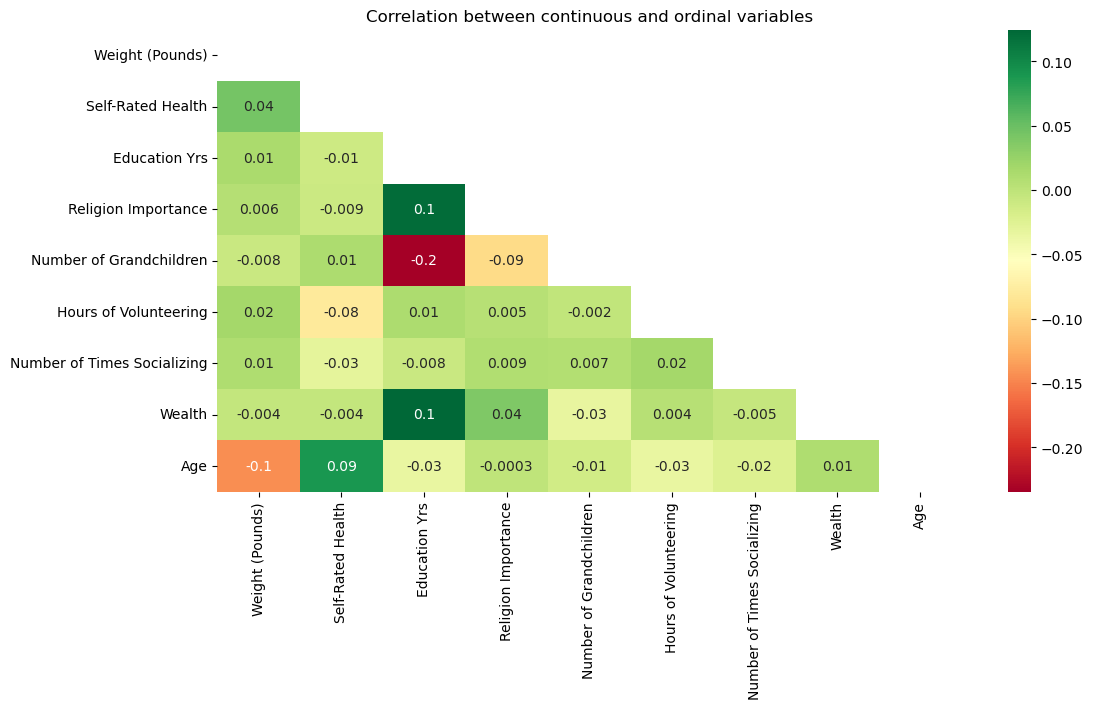

In [7]:
# Analyze the correlation amongst the continuous and ordinal variables
_, ax = plt.subplots(figsize=(12, 6))
# Create a mask to hide the upper triangle of the heatmap
matrix = np.triu(df02_d_ord.corr())
# Plot the heatmap
sns.heatmap(df02_d_ord.corr(), annot=True, fmt='.1g', cmap='RdYlGn', ax=ax,
            mask=matrix)
plt.title('Correlation between continuous and ordinal variables')
plt.show()

I also preprocess the binary variables in the dataset. 

First, I construct some binary variables based on categorical responses: whether the respondent has hypertension, diabetes, arthritis, smoking, drunk alcohol, married, children nearby, relatives nearby, and functional limitations. This is because HRS initially records the responses in high accuracy for nuances sociological research purposes. The category of 1 and 3 in the first 3 varaibles indicate "Yes" and "Disputes previous wave record, but now has condition". Here, we treat both of them as "Yes". In the other cases, the category of 1 indicates Yes and 3 or 5 indicates Ever Had and No respectively. Here, we also treat them as Yes and No.

Then, I address the missing values of the binary variables. They are coded as NA. I impute the missing values of the binary variables using the mode imputation method. I have also set the column names of the binary variables for the convenience of the analysis.

In [8]:
# Preprocessing the binary/categorical variables
cat_col = ['HC005', 'HC010', 'HC070', 'HC117', 'HC128', 'HMARITAL', 'HE012',
           'HF174', 'HG001',
           'HX060_R','HB031A']
df02_d_cat = df02_d[cat_col].copy()
# Check the number of missing values in original categorical variables
print("Missing values in the columns", "\n", df02_d_cat.isnull().sum())
# Fill the missing values with the mode of the variable
df02_d_cat.fillna(df02_d_cat.mode().iloc[0], inplace=True)
for i in cat_col[:3]:
    df02_d_cat[i] = df02_d_cat[i].isin([1, 3])
for i in cat_col[3:11]:
    df02_d_cat[i] = df02_d_cat[i].isin([1])
df02_d_cat.columns = ['Hypertension', 'Diabetes', 'Arthritis', 'Smoking',
                      'Drunk Alcohol', 'Married', 'Children Nearby',
                      'Relatives Nearby', 'Functional Limitations',
                      'Sex_Male', 'Race_White']
df02_d_cat

Missing values in the columns 
 HC005        663
HC010        663
HC070        663
HC117        786
HC128        663
HMARITAL       1
HE012       2107
HF174        669
HG001        671
HX060_R     2051
HB031A        41
dtype: int64


,Hypertension,Diabetes,Arthritis,Smoking,Drunk Alcohol,Married,Children Nearby,Relatives Nearby,Functional Limitations,Sex_Male,Race_White
0,False,False,False,False,True,True,False,False,False,True,True
1,False,False,True,False,False,True,False,False,False,False,True
2,False,False,False,False,False,False,True,False,False,True,True
3,True,False,False,False,False,False,True,False,False,False,True
4,True,False,True,False,True,True,True,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
20213,True,False,True,False,False,False,True,False,False,False,True
20214,True,False,True,False,False,False,True,False,False,False,True
20215,True,False,True,False,False,False,False,False,False,False,False
20216,True,False,True,False,False,True,True,False,False,False,True


From the earlier descriptive statistics in cleaning continuous variables, I see that the variable <code>age</code> variable includes the respondents aged below 51. This is because HRS sample collection is based on the households and include the spouse or partner of the main household respondent whose age may below 51. I will remove the respondents aged below 51 in the data cleaning process because they will bias the analysis. 

In [9]:
hrs_clean_full = pd.concat([df02_d['deceased'], df02_d_ord, df02_d_cat], axis=1)
hrs_clean = hrs_clean_full[hrs_clean_full['Age'] >= 51]
hrs_clean

,deceased,Weight (Pounds),Self-Rated Health,Education Yrs,Religion Importance,Number of Grandchildren,Hours of Volunteering,Number of Times Socializing,Wealth,Age,...,Diabetes,Arthritis,Smoking,Drunk Alcohol,Married,Children Nearby,Relatives Nearby,Functional Limitations,Sex_Male,Race_White
0,1.0,170.000000,3.000000,12.0,1.0,12.000000,20.00000,1.000000,0.0,66.000000,...,False,False,False,True,True,False,False,False,True,True
1,1.0,179.000000,3.000000,16.0,1.0,12.000000,100.00000,1.000000,0.0,64.000000,...,False,True,False,False,True,False,False,False,False,True
2,0.0,180.000000,2.000000,12.0,3.0,6.657524,45.70395,3.000000,0.0,63.000000,...,False,False,False,False,False,True,False,False,True,True
4,1.0,230.000000,2.000000,16.0,1.0,6.657524,200.00000,1.000000,0.0,63.000000,...,False,True,False,True,True,True,True,False,True,True
5,0.0,155.000000,1.000000,12.0,1.0,6.657524,40.00000,1.000000,0.0,56.000000,...,False,False,False,True,True,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20213,0.0,171.296493,2.868444,0.0,1.0,20.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,False,True,False,False,False,True
20214,0.0,171.296493,2.868444,14.0,1.0,2.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,False,True,False,False,False,True
20215,1.0,171.296493,2.868444,12.0,3.0,8.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,False,False,False,False,False,False
20216,1.0,171.296493,2.868444,15.0,5.0,2.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,True,True,False,False,False,True


In [10]:
hrs_clean.to_csv('hrs_clean.csv', index=False)

### S2: Pipeline: Feature Selection, Parameter Tuning, and Model Training

Now, moving on to the machine learning part of the analysis. I will first use the pipeline to select the features, tune the parameters, and validate the data. The pipeline will be used to train the following algorithms: logistic regression, neural network, and BNN.

First, I split the sample into training and testing data with shuffle that allows the random permutations. BY doing so, I try to prevent the knowledge leakage from test dataset during the process of feature selection and parameter tuning. I will use the training dataset to select the features and tune the parameters. Then, I will use the testing dataset to validate the model performance.

After splitting the dataset, there are 15809 observations in the training dataset and 3953 observations in the testing dataset.

The variable distribution shows a similar distribution between the training and testing datasets and the outcome variable is roughly balanced in both datasets.

In [11]:
hrs_df = pd.read_csv('hrs_clean.csv')

y_df = hrs_df[['deceased']]
X_df = hrs_df.drop(columns=['deceased'], inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    shuffle=True)

# check the data size after splitting
print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)
print("y_train size: ", y_train.shape)
print("y_test size: ", y_test.shape)

X_train size:  (15809, 20)
X_test size:  (3953, 20)
y_train size:  (15809, 1)
y_test size:  (3953, 1)


In [12]:
# check the distribution of the target variable in the train and test data
print("y_train distribution: \n", y_train['deceased'].value_counts())
print("y_test distribution: \n", y_test['deceased'].value_counts())

y_train distribution: 
 0.0    8535
1.0    7274
Name: deceased, dtype: int64
y_test distribution: 
 0.0    2115
1.0    1838
Name: deceased, dtype: int64


In [17]:
logreg = LogisticRegression(random_state=seed, solver='liblinear', max_iter=1000)

parameters = [{'penalty':['l1', 'l2'],},
              {'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 2, 3, 4, 5, 6, 7, 8]}]

grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 5,
                           verbose=0)

grid_search.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='liblinear'),
             param_grid=[{'penalty': ['l1', 'l2']},
                         {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 2, 3, 4,
                                5, 6, 7, 8]}],
             scoring='f1')

In [ ]:
#describe parameter tuning grid search CV before doing LR
#get the best parameter -> show the best f1 score

##grid search for LR, Naiv Bayes
# show parameter tuning grid search CV results in markdown
# show classification report, plot ROC, and show confusion matrix
# qualitative measures of errors: top positive features, error analysis

#interpret model performance by harmonizing three types of evaluations

### S3: Model Evaluation (On Test Set) and Error Analysis

### Conclusion

Within the project above, I have used the HRS dataset to predict mortality in the next 14 years using the baseline characteristics in 2002. I have also discussed the social and demographic characteristics of the cases whose disposition statuses were either wrongly predicted as death or alive by the algorithms. Specifically, I have used a Logistic Regression Classifer, a Neural Network Classifer, and a BNN Classider. The following was the pipeline of the project:

1. Exploratory Data Analysis & Data Preprocessing: I have merged the files of the HRS dataset of each wave (e.g., 2002) into one dataframe. Then, I have checked whether the outcome variable is balanced. After checking the balance of the outcome variable and the missingness of the predictors, I will go ahead to preprocess the data for the analysis by 1) imputing the missing values separately for continuous and categorical variables 2) construct some variables based on multiple other variables 3) scaling the continuous variables.
2. Pipeline: Feature Selection, Parameter Tuning, and Model Training: I have used the pipeline to select the features, tune the parameters, and validate the data. The pipeline used the following algorithms to train the model: logistic regression, neural network, and BNN.
3. Model Evaluation (On Test Set) and Error Analysis: I have evaluated the models on the test set and analyzed the errors of the models. I have also discussed the social and demographic characteristics of the cases whose disposition statuses were either wrongly predicted as death or alive by the algorithms.

Overall the findings will serve important purposes for public health practitioners in understanding the risk and protective factors of mortality in the aging process. When comparing between model performances in accurately predicting mortality, BNN has the highest accuracy and the lowest false positive rate. However, the BNN model is computationally expensive. Hence, I would recommend the logistic regression model for the public health practitioners who are interested in the risk and protective factors of mortality in the aging process. The logistic regression model has the second highest accuracy and the second lowest false positive rate. It is also computationally less expensive than the BNN model.

Future avenues of research include the following (as I will collaborate with Zejian on our conference presentation this October):
1. Comparing and contrasting the differences in the important predictors of mortality between the NSHAP, WLS and HRS datasets.
2. Proposing the best model for predicting mortality in the aging process based on the differences in the important predictors of mortality between the NSHAP, WLS and HRS datasets.